**参数设置**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,fftshift,ifft


'''参数设置'''
T_0=50   #激光脉冲半高全宽（fs）
W=100    #激光能量（微J）
r=10     #光束半径（微米）
pi=np.pi
phi=pi/2      #相对相位
eta=0.2       #倍频效率


c=3e8               #光速（m/s）
epsilon_0=885e-14   #真空介电常数（F/m）
k=c*epsilon_0/2
k

0.0013275000000000001

**双色激光场**

In [4]:
T_1=T_0/((2*np.log(2))**0.5)      #基波脉宽
T_2=T_1/(2**0.5)                  #二次谐波脉宽

I=((2/pi)**1.5)*(W/((r**2)*T_1)) #脉冲光强 *10**17 W*cm**-2
I_1=I/1.2                         #基波光强
I_2=I/6                           #二次谐波光强

E1=(I_1/k)**0.5   #基波电场 *10**10  V*m**-1
E2=(I_2/k)**0.5   #二次谐波电场
print(I,E1,E2)

0.011961286930387841 2.7401924559757598 1.2254513205987796


In [5]:
def t():
    return np.linspace(-100,100,3000) #时间范围
t = t()
dt=0.1
f_w=3000/200
f_w

15.0

In [6]:
lam=800         #波长
f=c*10**-6/lam #频率THz

w=2*pi*f       #角频率   
f

0.375

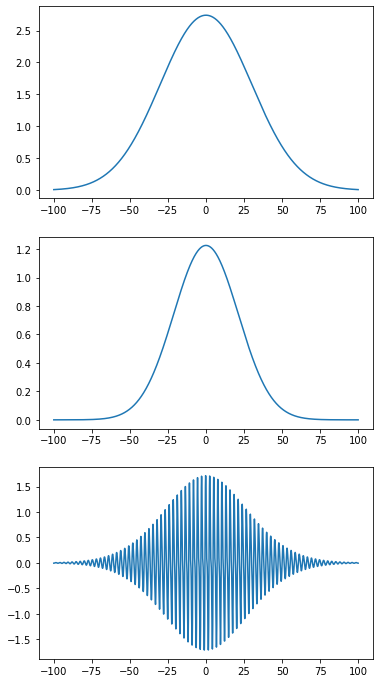

In [7]:
def E_w(t):
    return ( E1 * np.exp(-(t / T_1) ** 2))    #基波场
def E_2w(t):
    return ( E2 * np.exp(-(t / T_2) ** 2))    #二次谐波场
            
def E(t):
    return (E_w(t) * np.cos(w * t) + E_2w(t) * np.cos(2 * w * t + phi))/2  #双色场

plt.figure(figsize=(6,12)) 

plt.subplot(311)
plt.plot(t,E_w(t))

plt.subplot(312)
plt.plot(t,E_2w(t))

plt.subplot(313)
plt.plot(t,E(t))

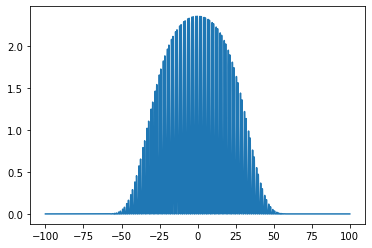

In [8]:
'''一阶电离率 经验公式'''

w_a=1#4.13*10
E_a=3#5.14
def W1(t):
    Ee = 0.0000001 + abs(E(t))             #  防止分母为零
    U1,Uh = 15.6, 13.6       #Uh 、 ⁢U1 分别是氢原子电离势和氮气分子一阶电离势
    W1 =4  * w_a * (U1 / Uh) ** 2.5 * (E_a/ Ee) * np.exp(-2 / 3 * (U1 / Uh) ** 1.5 * (E_a/ Ee))
    return W1

#plt.figure(figsize=(3,6))

plt.plot(t,W1(t))

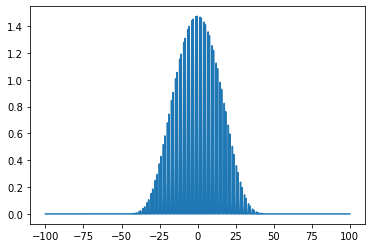

In [9]:
'''二阶电离率 经验公式'''

def W2(t):
    Ee = 0.0000001 + abs(E(t))             #  防止分母为零
    U2,Uh = 27.1, 13.6       #Uh 、⁢U2 分别是氢原子电离势和氮气分子二阶电离势
    W2 = 4 * w_a * (U2 / Uh) ** 2.5 * (E_a / Ee) * np.exp(-2 / 3 * (U2 / Uh) ** 1.5 * (E_a/ Ee))
    return W2

plt.plot(t,W2(t))

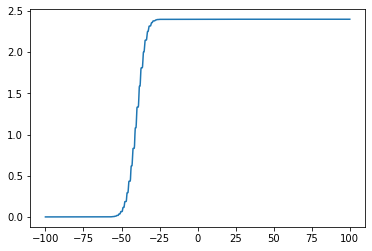

In [10]:
'''只考虑一阶电离的电子电子密度'''
def Ne_1(t):
    
    Ng = 2.4 #* 10 **19       #initial density of neutral particles
    
    Ne_1 = np.zeros(len(t),float)    
    Ne_1[0] = Ng* W1(t)[0]
    
    for i in range(len(t) - 1):
        Ne_1[i + 1] = Ne_1[i] + (Ng - Ne_1[i]) * W1(t)[i+1]* (t[i+1]-t[i])
    return Ne_1

plt.plot(t,Ne_1(t))  #前100-1500个数据绘图

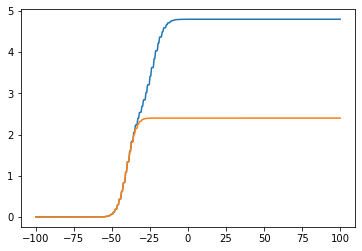

In [11]:
'''考虑一阶电离和二阶电离的电子密度'''
def Ne(t):
    
    Ng = 2.4 #* 10 ** 19   #initial density of neutral particles
    
    Ne_1 = np.zeros(len(t),float)    #numpy.zeros(shape,dtype=float,order='C'）创建0矩阵
    Ne_2 = np.zeros(len(t),float)                                #len()字符元组的大小
    
    Ne_1[0] = Ng* W1(t)[0]
    Ne_2[0] = Ne_1[0]*W2(t)[0]
    
    for i in range(len(t) - 1):
        Ne_1[i + 1] =Ne_1[i] + (Ng - Ne_1[i]) * W1(t)[i+1] * (t[i+1]-t[i])
        Ne_2[i + 1] = Ne_2[i] + (Ne_1[i] - Ne_2[i])*W2(t)[i+1] * (t[i+1]-t[i])
    return Ne_1+Ne_2
plt.plot(t,Ne(t))
plt.plot(t,Ne_1(t))




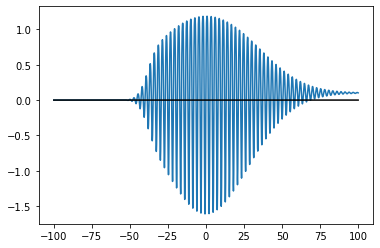

In [12]:
def J_1(t):
    
    dJ_1_dt=Ne_1(t)*E(t)
    J_1=np.zeros(len(t),float)
    J_1[0]=Ne_1(t)[0]*E(t)[0]
    
    for i in range(len(t)-1):
        J_1[i+1]=J_1[i]+dJ_1_dt[i]*(t[i+1]-t[i])
    return J_1

y=np.zeros(len(t),float)
plt.plot(t,J_1(t))
plt.plot(t,y,color='black')

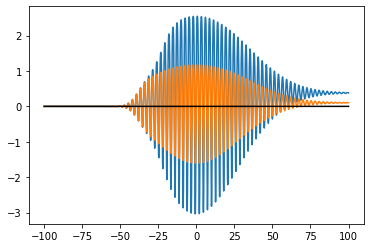

In [13]:
def J(t):
    dJ_dt=Ne(t)*E(t)
    J=np.zeros(len(t),float)
    J[0]=Ne(t)[0]*E(t)[0]
    
    for i in range(len(t)-1):
        J[i+1]=J[i]+dJ_dt[i+1]*(t[i+1]-t[i])
    return J


plt.figure()
plt.plot(t,J(t))
plt.plot(t,J_1(t))
plt.plot(t,y,color='black')

'\nplt.subplot(3,1,2)\nplt.plot(fft_E)       #频谱图\n\nplt.subplot(3,1,2)\nplt.plot(abs_E)       #取模的频谱\nplt.axis([0,500,0,250])\n'

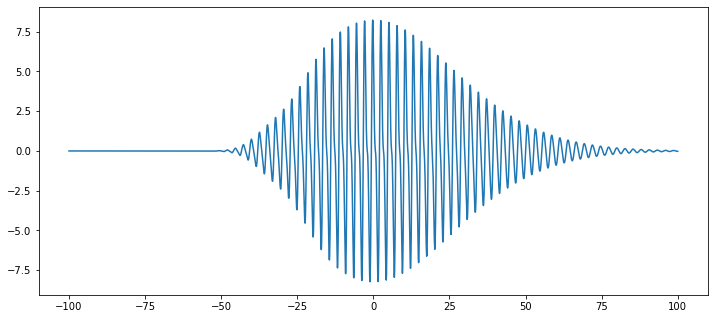

In [14]:

'''辐射电磁波的电场'''
def dJ_dt_1(t):
    return Ne_1(t)*E(t)
def dJ_dt(t):
    return Ne(t)*E(t)


E=dJ_dt(t)

plt.figure(figsize=(12,18))

plt.subplot(3,1,1)
plt.plot(t,E)   #原始图
#plt.plot(t,dJ_dt_1(t))


fft_E=fft(E)   #傅里叶变换（复数）
abs_E=abs(fft_E)      #取绝对值  （复数的模） 

'''
plt.subplot(3,1,2)
plt.plot(fft_E)       #频谱图

plt.subplot(3,1,2)
plt.plot(abs_E)       #取模的频谱
plt.axis([0,500,0,250])
'''

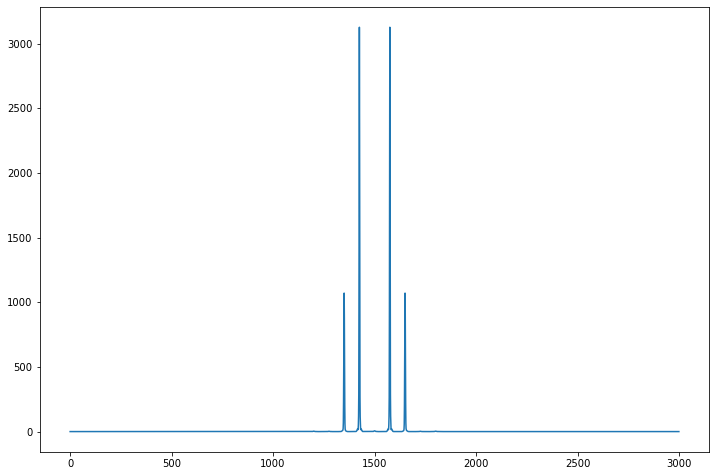

In [15]:
shift_E=fftshift(fft_E)   #移频
abs_s_E=abs(shift_E)             #移频取绝对值

plt.figure(figsize=(12,18))

plt.subplot(2,1,1)
plt.plot(abs_s_E)  #移频取绝对值的图
#plt.axis([1000,2000,0,250])


'\nplt.subplot(2,1,2)\nplt.plot(half_t,nor_half_E)  #归一化一半区间图\n'

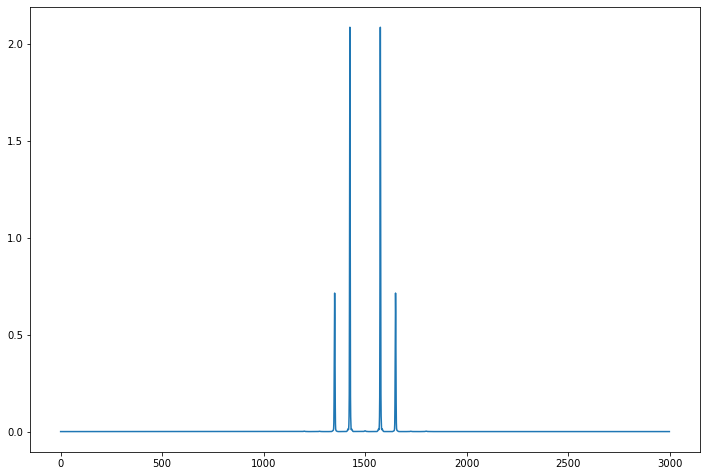

In [54]:
nor_E=abs_s_E/((len(t)/2))                  #移频归一化处理（双边频谱） 

nor_half_E = nor_E[range(int(len(t)/2))]    #由于对称性，只取一半区间（单边频谱

tf=np.arange(len(t))          #频率
half_t = tf[range(int(len(t)/2))]  #取一半区间


plt.figure(figsize=(12,18))
plt.subplot(2,1,1)
plt.plot(nor_E)  #归一化处理图
#plt.axis([1400,1500,0,0.01])



'''
plt.subplot(2,1,2)
plt.plot(half_t,nor_half_E)  #归一化一半区间图
'''


In [19]:
MAS=max(nor_E)
MAS

2.0838981195909723

In [24]:
for i in range(len(t)):
    if nor_E[i]==max(nor_E):
        print(i)


1425
1575


In [45]:
k=2*f*1000/(1575-1425)
b=-1500*k
T_100=(100-b)/k
T_100

1520.0

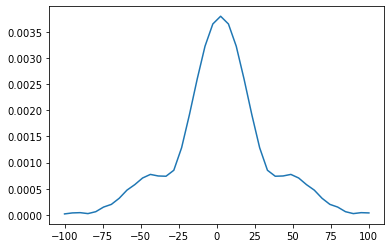

In [49]:
THz_P=np.zeros(40,float)     #30000
THz_P[0:40]=nor_E[1480:1520]
THz_P
tp=np.linspace(-100,100,40)


plt.plot(tp,THz_P)
#plt.plot(THz_P)
#plt.axis([0,100,0,0.005])


#plt.plot(fftshift(ifft(THz_P)))
#plt.axis([40,60,0,0.001])

In [51]:
max(THz_P)

0.0037966771998829037

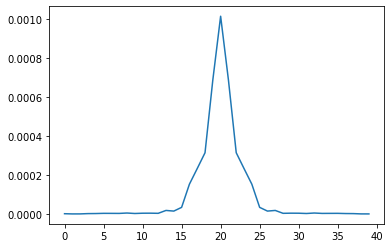

In [53]:
THz_S=fftshift(ifft(THz_P))
ts=np.linspace(-)
plt.plot(abs(THz_S))

In [52]:
max(abs(fftshift(ifft(THz_P))))

0.001014993918942683